Load Julia packages (libraries) needed

In [1]:
using TuringModels
using Optim, Turing, Flux.Tracker
gr(size=(600,300));

In [2]:
Turing.setadbackend(:reverse_diff);
Turing.turnprogress(false);

┌ Info: [Turing]: global PROGRESS is set as false
└ @ Turing /Users/rob/.julia/packages/Turing/UXxKz/src/Turing.jl:24


### snippet 2.8t

Define the data

In [3]:
k = 6; n = 9;

Define the model

In [4]:
@model globe_toss(n, k) = begin
  theta ~ Beta(1, 1) # prior
  k ~ Binomial(n, theta) # model
  return k, theta
end;

Compute the "maximum_a_posteriori" value

Set search bounds

In [5]:
lb = [0.0]; ub = [1.0];

Create (compile) the model

In [6]:
model = globe_toss(n, k);

Use Turing mcmc

In [7]:
chn = sample(model, NUTS(2000, 200, 0.65));

┌ Info: [Turing] looking for good initial eps...
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/support/hmc_core.jl:240
[NUTS{Turing.Core.FluxTrackerAD,Union{}}] found initial ϵ: 0.8
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/support/hmc_core.jl:235
┌ Warning: 15.116776869842457 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.63353132291871 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 8.240780997391646 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/stepsize.jl:96
┌ Warning: 5.186569902831925 exceeds 5.0; capped to 5.0 for numerical stability
└ @ Turing.Inference /Users/rob/.julia/packages/Turing/UXxKz/src/inference/adapt/s

Look at the generated draws (in chn)

In [8]:
describe(chn)

Iterations = 1:2000
Thinning interval = 1
Chains = 1
Samples per chain = 2000

Empirical Posterior Estimates:
             Mean         SD       Naive SE       MCSE        ESS   
  lf_num  0.000000000 0.00000000 0.0000000000 0.0000000000       NaN
 elapsed  0.002717103 0.08462169 0.0018921986 0.0024155559 1227.2393
 epsilon  0.991234273 0.32240576 0.0072092119 0.0193377773  277.9665
   theta  0.639944642 0.13576219 0.0030357348 0.0045416285  893.5821
      lp -3.282363379 0.70133195 0.0156822591 0.0198169363 1252.4899
eval_num  6.823000000 3.35831954 0.0750943079 0.0892574632 1415.6469
  lf_eps  0.991234273 0.32240576 0.0072092119 0.0193377773  277.9665

Quantiles:
              2.5%         25.0%        50.0%         75.0%         97.5%    
  lf_num  0.0000000000  0.000000000  0.000000000  0.00000000000  0.0000000000
 elapsed  0.0001404789  0.000149118  0.000174679  0.00038573725  0.0005031048
 epsilon  0.5604342929  0.963158281  0.963158281  0.96315828051  1.5844602077
   theta  0.36

Look at the mean and sd

In [9]:
println("\ntheta = $(mean_and_std(chn[:theta][201:2000]))\n")


theta = (0.6373709104644278, 0.13562625907198678)



Fix the inclusion of adaptation samples

In [10]:
chn2 = MCMCChain.Chains(chn.value[201:2000,:,:], names=chn.names)

Object of type "Chains{Float64}"

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Union{Missing, Float64}[0.0 0.0248511 … 10.0 0.963158; 0.0 0.000577618 … 10.0 0.963158; … ; 0.0 0.000378367 … 10.0 0.963158; 0.0 0.000475768 … 10.0 0.963158]

Look at the proper draws (in corrected chn2)

In [11]:
describe(chn2)

Iterations = 1:1800
Thinning interval = 1
Chains = 1
Samples per chain = 1800

Empirical Posterior Estimates:
              Mean                SD                     Naive SE                     MCSE               ESS   
  lf_num  0.0000000000 0.0000000000000000000000 0.000000000000000000000000 0.000000000000000000000000       NaN
 elapsed  0.0003015875 0.0007268922607635600833 0.000017133014892597781995 0.000020802995756092877992 1220.9232
 epsilon  0.9631582805 0.0000000000000013326379 0.000000000000000031410576 0.000000000000000026926864 1800.0000
   theta  0.6373709105 0.1356262590719867766609 0.003196741583225511627864 0.004054506164231977231871 1118.9525
      lp -3.2741986344 0.6815120683232366305404 0.016063393499061009994655 0.017971085142472857654194 1438.1312
eval_num  6.7533333333 2.9906729198658088542118 0.070490836731602848908018 0.081006737394293176768301 1362.9991
  lf_eps  0.9631582805 0.0000000000000013326379 0.000000000000000031410576 0.000000000000000026926864 1800

Compute at hpd region

In [12]:
bnds = MCMCChain.hpd(chn2[:, 4, :], alpha=0.06);

analytical calculation

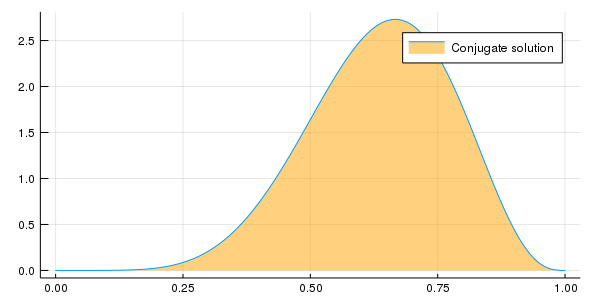

In [13]:
w = 6; n = 9; x = 0:0.01:1
plot( x, pdf.(Beta( w+1 , n-w+1 ) , x ), fill=(0, .5,:orange), lab="Conjugate solution")

quadratic approximation

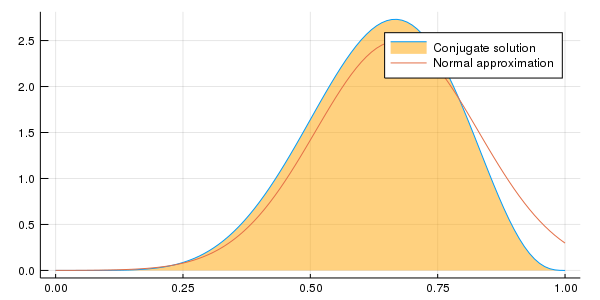

In [14]:
plot!( x, pdf.(Normal( 0.67 , 0.16 ) , x ), lab="Normal approximation")

Turing Chain &  89%hpd region boundaries

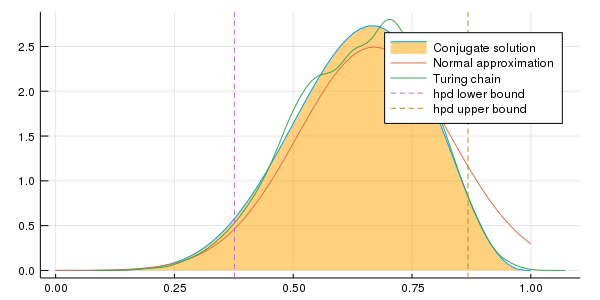

In [15]:
#tmp = convert(Array{Float64,3}, chn.value[:, 4, :])
#draws = reshape(tmp, (size(tmp, 1)*size(tmp, 3)),)
density!(chn.value[:, 4, 1], lab="Turing chain")
vline!([bnds.value[1]], line=:dash, lab="hpd lower bound")
vline!([bnds.value[2]], line=:dash, lab="hpd upper bound")

Show hpd region

In [16]:
println("hpd bounds = $bnds\n")

hpd bounds =        94% Lower  94% Upper
theta 0.37638787 0.86775407





End of `clip_08t.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*